# ALL Imports

In [1]:
import random

import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.io import wavfile
from IPython.display import Audio
import sympy as smp
from scipy.integrate import odeint

# Задание 0: Оценка pi (разогрев)

Найдите приблизительное значение числа $\pi$ с помощью метода Монте-Карло

Возможно вам понадобидся NumPy

In [2]:
circle_points = 0
square_points = 0

for i in range(int(1e7)):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    if x**2 + y**2 <= 1:
        circle_points += 1
    square_points += 1
    
pi = 4 * circle_points / square_points 
pi

3.1416636

# Задание 1: ЭЭГ и FFT

При закрытии глаз у приблизительно 90% людей на электроэнцефалограмме (ЭЭГ) увеличивается амплитуда гармоник, лежащих в диапазоне от 8 до 12 Гц (альфа-ритм).

В приложенном файле (input.txt) находятся два отрывка сигнала ЭЭГ, записанных с одного канала во время одной и той же сессии при открытых и закрытых глазах. Известно, что у испытуемого наблюдается усиление альфа-ритма при закрытии глаз.
Напишите программу, которая определяет, какой из двух отрывков был записан с закрытыми глазами.

Частота оцифровки сигнала 128 Гц. Каждый отрезок сигнала представлен последовательностью действительных чисел, разделённых пробелом. Отрезки разделены символом переноса на новую строку. Программа должна вывести 1 или 2 $-$ номер строки, отрывок энцефалограммы которой имеет большую мощность альфа-ритма.

In [3]:
def alpha_rhythm_power(signal: list[float]):
    fft = np.fft.fft(signal)
    return np.sum(np.abs(fft[8:13]))

with open("input.txt", "r") as text:
    line1 = list(map(float, text.readline().split(',')))
    line2 = list(map(float, text.readline().split(',')))

arp_1 = alpha_rhythm_power(line1)
arp_2 = alpha_rhythm_power(line2)
result = 1 if arp_1 > arp_2 else 2
result

1

# Задание 2: Numba и WAV

### Волновое уравнение (базовое)

$$\large \frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} = 0$$

### Полноценное (можно имитировать гитарные струны) уравнение

$$\large \frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} -\gamma \frac{\partial y}{\partial t} - l^2 \frac{\partial^4 y}{\partial x^4} = 0$$

при 


$$y(0, t) = y(L, t) = 0, y(x, 0) = f(x)$$

$y -$ амплитуда струны, $x -$ положение струны, $t -$ время.

Параметры:
* $c - $ скорость волны ($\frac{\text{м}}{\text{сек}}$)
* $\gamma - $ постоянная демпфирования ($\frac{\text{сек}}{\text{м}}$)
* $l - $ коэффициент жесткости (характеристическая длина).

Дискретная форма:

$$\frac{y_{j+1}^{m} -2y_{j}^{m} + y_{j-1}^{m}}{\Delta x^2} - \frac{1}{c^2} \frac{y_{j}^{m+1} -2y_{j}^{m} + y_{j}^{m-1}}{\Delta t^2} - \gamma \frac{y_{j}^{m+1} - y_{j}^{m-1}}{2\Delta t} - l^2 \frac{y_{j-2}^{m} - 4y_{j-1}^{m} + 6y_{j}^{m} - 4y_{j+1}^{m} + y_{j+2}^{m}}{\Delta x^4} = 0$$

Найти $y_{j}^{m + 1} -$ амплитуду струны в следующий ($(m+1)$-й) момент времени:

$$y_{j}^{m+1} = \bigg[\frac{1}{c^{2}\Delta t^2} + \frac{\gamma}{2\Delta t} \bigg]^{-1}\bigg[\frac{1}{\Delta x^2}(y_{j+1}^{m} -2y_{j}^{m} + y_{j-1}^{m}) - \frac{1}{c^{2}\Delta t^2}(y_{j}^{m+1} - 2y_{j}^{m-1}) + \frac{\gamma}{2\Delta t} y_{j}^{m-1} - \frac{l^2}{\Delta x^4} (y_{j-2}^{m} - 4y_{j-1}^{m} + 6y_{j}^{m} - 4y_{j+1}^{m} + y_{j+2}^{m})
\bigg]$$

Для устойчивости необходимо $\frac{c\Delta t}{\Delta x} < 1$.

## Решение

* Длина гитарной струны $L = 0.7$ м
* $\Delta x = 0.7$ мм, то есть $N_{x} = 101$ положений гитарной струны
* Фундаментальная частота гитарной ноты $f = \frac{c}{2L}$. Ноте "Ля" малой октавы соответствует частота $220$ Hz и  скорость волны $c = 308$ м/c <br>
($f \cdot 2 \cdot L = 220 \cdot 2 \cdot 0.7 = 308$) <a href="https://www.physicsclassroom.com/class/sound/Lesson-5/Guitar-Strings"> Детали</a>
* Для устойчивости выбираем $\Delta t = 5 \times 10^{-6}$ сек. Чтобы в результате было минимум несколько секунд, выбираем $N_{t} = 500\_000$ 
* $l = 2 \times 10^{-6}$, $\gamma = 2.6 \times 10^{-5} \frac{\text{сек}}{\text{м}}$

In [4]:
Nx = 101
Nt = 500000
L = 0.7
dx = L / (Nx - 1)
f = 220
c = 2 * L * f
dt = 5e-6
l = 5e-5
gamma = 5e-5

Начальное положение струны (натянули ее и получился треугольник)

In [5]:
y_start = np.linspace(0, 0.01, 20)
y_end = np.linspace(0.01, 0, 81)
y0 = np.concatenate([y_start, y_end])

График $y_{0}$ от $t$ с соотношением сторон 5 к 1

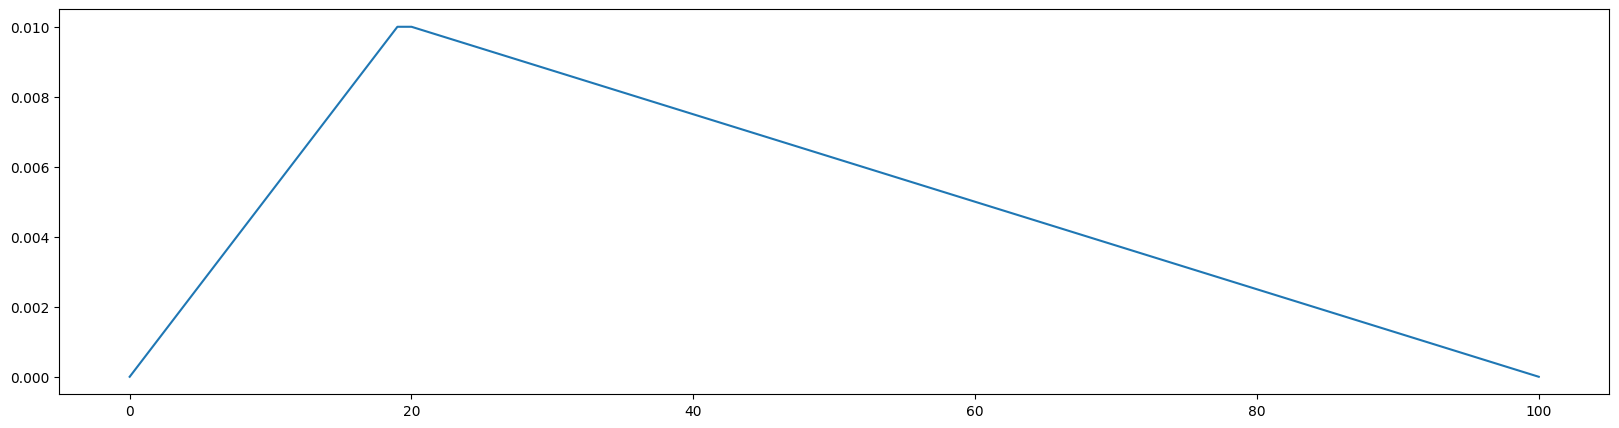

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(y0)

Создаем двумерный массив $y(x, t)$ и заполняем его нулями.

In [7]:
sol = np.zeros((Nt, Nx))

При $t=0$ и $t=1$, нужно чтоб считать формулке выше

In [8]:
sol[0] = y0
sol[1] = y0

Пишем функцию, которая высчитывает $y$

In [9]:

# сначала что возвращается, потом аргументы функции
@jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute(d, Nt, Nx, dt, dx, l, gamma):
    for t in range(1, Nt-1):
        for i in range(2, Nx-2):
            multiplier = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            term_1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            term_2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            term_3 = gamma/(2*dt) * d[t-1][i]
            term_4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = multiplier * (term_1 - term_2 + term_3 - term_4)
    return d

In [10]:
sol = compute(sol, Nt, Nx, dt, dx, l, gamma)

Строим некоторые положения струны

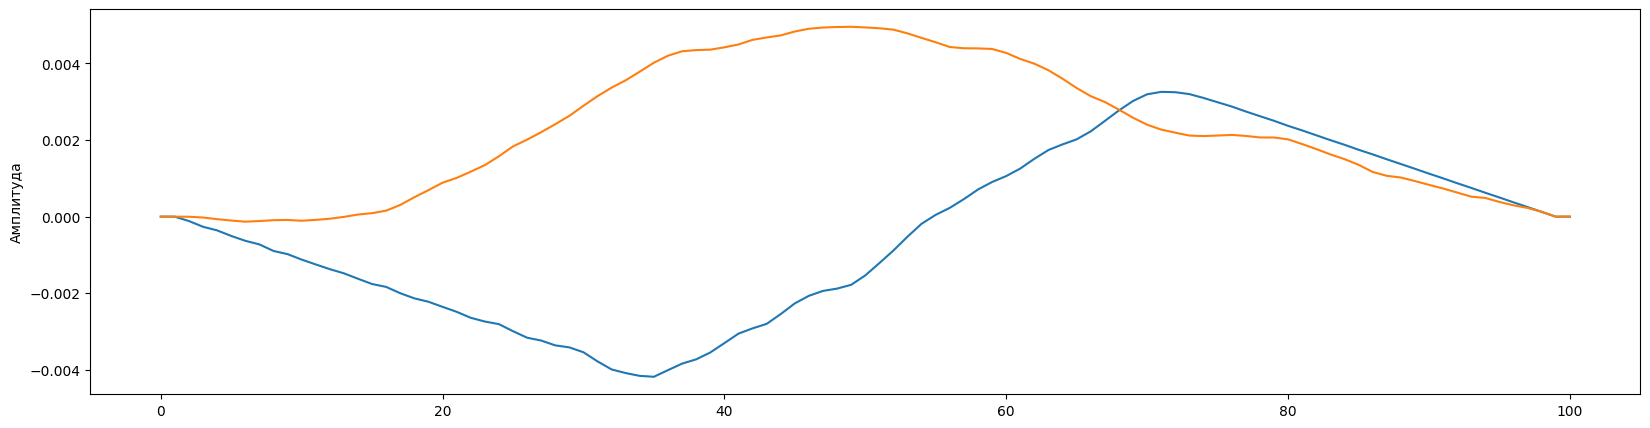

In [11]:
plt.figure(figsize=(20,5))
plt.plot(sol[239])
plt.plot(sol[23942])
plt.ylabel('Амплитуда')
plt.savefig('string_at_sample_points.png')


### Создайте анимацию

Одна секунда это $\frac{1}{dt}$ кадров (fps)

Если взять каждый 10-й кадр, то fps уменьшится в 10 раз. 

В нашей задаче $\Delta t = 5\times 10^{-6} \Rightarrow 200000$ fps

Если у gif-файла указать fps 20, то анимация будет в 1000 раз медленнее реальной

У
```python
animation.FuncAnimation()
```

обратите внимание на аргументы ```frames``` и ```interval```

У метода ```save``` обратите внимание на ```writer``` и ```fps```

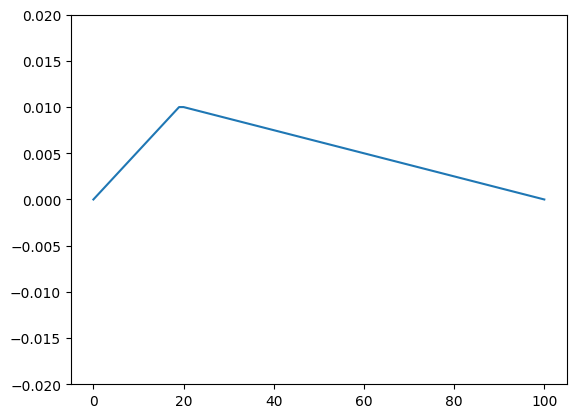

In [12]:
def animate(i):
    ax.clear()
    ax.plot(sol[i*10])
    ax.set_ylim(-0.02, 0.02)
    
fig, ax = plt.subplots(1,1)
ax.set_ylim(-0.05, 0.05)
ani = animation.FuncAnimation(fig, animate, frames=200, interval=100)
ani.save('string_animation.gif', writer='pillow', fps=20)

## Создать музыкальный файл .WAV

Извлечь "количество" гармоник в любой момент времени $t$ можно по формуле

$$\int_{0}^{L} y(x, t) \sin(\frac{n\pi x}{L})dx$$

$n~-$ номер гармоники.

Функция рассчета интеграла

In [13]:
def calc_integral(n):
    lp = np.linspace(0,1,101)
    arr = np.sin(n*np.pi*lp)
    return np.array([sum(arr*s) for s in sol])


In [14]:
harmonics = [calc_integral(n) for n in range(20)]

Складываем гармоники

In [15]:
sum_harmonics = sol.sum(axis=1)[::20]
sum_harmonics = sum_harmonics.astype(np.float32)

Делаем WAV файл

In [16]:
wavfile.write('sample_sound.wav', 20_000, sum_harmonics)

Проигрыш

In [17]:
Audio('sample_sound.wav')

# Задание 3: Двойной маятник


Смоделировать движение двойного маятника с помощью символьных вычислений (SymPy).

Обозначения взять с картинки с $\href{https://ru.wikipedia.org/wiki/%D0%94%D0%B2%D0%BE%D0%B9%D0%BD%D0%BE%D0%B9_%D0%BC%D0%B0%D1%8F%D1%82%D0%BD%D0%B8%D0%BA}{википедии}$

* $t$ - время
* $m_1, m_2$ - массы стержней
* $l_1, l_2$ - длины стержней
* g - гравитационная постоянная
* $I_1, I_2$ - моменты инерции стержней

In [18]:
t, m1, m2, g, l1, l2, I1, I2 = smp.symbols('t m_1 m_2 g l_1 l_2 I_1 I_2')

$\theta_{1}$ и $\theta_{2}$ $-$ функции от времени 

In [19]:
the1, the2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)

In [20]:
the1 = the1(t)
the2 = the2(t)

Определим производные

In [21]:
the1_d = smp.diff(the1, t)
the1_dd = smp.diff(the1_d, t)

the2_d = smp.diff(the2, t)
the2_dd = smp.diff(smp.diff(the2, t), t)

определим $x_1, y_1, x_2, y_2$

In [22]:
x1, y1, x2, y2 = smp.symbols('x_1, y_1, x_2, y_2', cls=smp.Function)
x1 = x1(the1, l1)
y1 = y1(the1, l1)
x2 = x2(the1, l1, the2, l2)
y2 = y2(the1, l1, the2, l2)

In [23]:
x1 = l1*smp.sin(the1)
y1 = -l1*smp.cos(the1)
x2 = l1*smp.sin(the1) + l2*smp.sin(the2)
y2 = -l1*smp.cos(the1) - l2*smp.cos(the2)

найдём лагранжиан как разность кинетической и потенциальной энергий по формуле из вики:

$$
L = \frac{1}{2}m({\dot{x}}_{1}^{2} + {\dot{y}}_{1}^{2} + {\dot{x}}_{2}^{2} + {\dot{y}}_{2}^{2}) + \frac{1}{2}I\big({\dot{\theta}}_{1}^{2} + {\dot{\theta}}_{2}^{2} \big) - mg(y_{1} + y_{2})
$$

In [24]:
V = m1*g*y1 + m2*g*y2
T_first_term = 0.5*m1*(smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T_second_term = 0.5*m2*(smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T_third_term = 0.5*I1*the1_d**2 + 0.5*I2*the2_d**2
T = T_first_term + T_second_term + T_third_term
L = T - V

Уравнения Лагранжа:

$
\begin{align}
    \frac{\partial L}{\partial \theta_{1}} - \frac{d}{dt} \frac{\partial L}{\partial {\dot{\theta}}_{1}} &= 0 \\
    \frac{\partial L}{\partial \theta_{2}} - \frac{d}{dt} \frac{\partial L}{\partial {\dot{\theta}}_{2}} &= 0
\end{align}
$

In [25]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t)
LE1 = LE1.simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t)
LE2 = LE2.simplify()

Решаем уравнения Лагранжа

In [26]:
sols = smp.solve(
    [LE1, LE2], 
    (the1_dd, the2_dd),
    simplify=False, 
    rational=False
)

Теперь есть вторые производные

$
\begin{align}
\frac{d^{2}\theta_{1}}{dt^2} &= \dots\\
\frac{d^{2}\theta_{2}}{dt^2} &= \dots
\end{align}
$

**NB**: в python можем решать ODE только первого порядка (у нас они второго!) 

Делаем классическую замену 
$\frac{dz_{1}}{dt} = \dots, \frac{d\theta_{1}}{dt} = z_{1}$

Теперь уже можно переходить от символьных выражений к численным функциям с помощью **lambdify**

In [27]:
dz1dt_f = smp.lambdify((m1, m2, g, the1, the2, l1, l2, I1, I2, the1_d, the2_d), sols[the1_dd])
dz2dt_f = smp.lambdify((m1, m2, g, the1, the2, l1, l2, I1, I2, the1_d, the2_d), sols[the2_dd])

dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Определим вектор $S = (\theta_{1}, z_{1}, \theta_{2}, z_{2})$

Воспользуемся ODE solver'ом:

In [28]:
def dSdt(S, t):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(m1,m2,g,the1,the2,l1,l2,I1,I2,z1,z2),
        dthe2dt_f(z2),
        dz2dt_f(m1,m2,g,the1,the2,l1,l2,I1,I2,z1,z2)
    ]

решаем систему ODE с помощью ```odeint```

In [29]:
t = np.linspace(0, 20, 1000)
g = 9.81
m1 = 1
m2 = 2
l1 = 1
l2 = 2
I1 = 1/12 * m1*l1**2
I2 = 1/12 * m2*l2**2
ans = odeint(dSdt, y0=[np.pi/2,0,(3/2)*np.pi/2,0], t=t)

получим $\theta_{1}$ и $\theta_{2}$ из ответа:

In [30]:
the1 = ans.T[0]
the2 = ans.T[2]

построим $\theta_{2}(t)$

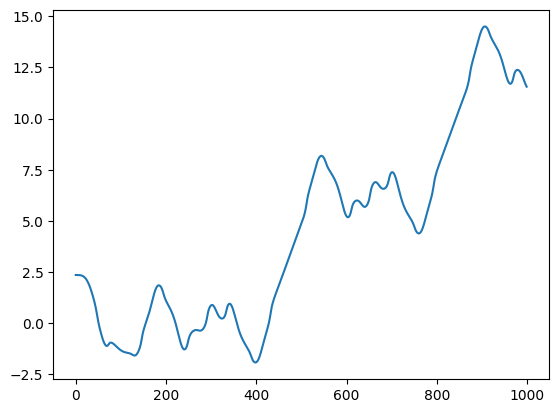

In [31]:
import matplotlib.pyplot as plt
plt.plot(the2)

реализуйте функцию, принимающую на вход $\theta_{1}$ и $\theta_{2}$ и возвращающую позиции двух масс

In [32]:
def get_x1y1x2y2(the1, the2):
    return (
        l1*np.sin(the1),
        -l1*np.cos(the1),
        l1*np.sin(the1) + l2*np.sin(the2),
        -l1*np.cos(the1)-l2*np.cos(the2)
    )

In [33]:
x1, y1, x2, y2 = get_x1y1x2y2(ans.T[0], ans.T[2])

анимируем!

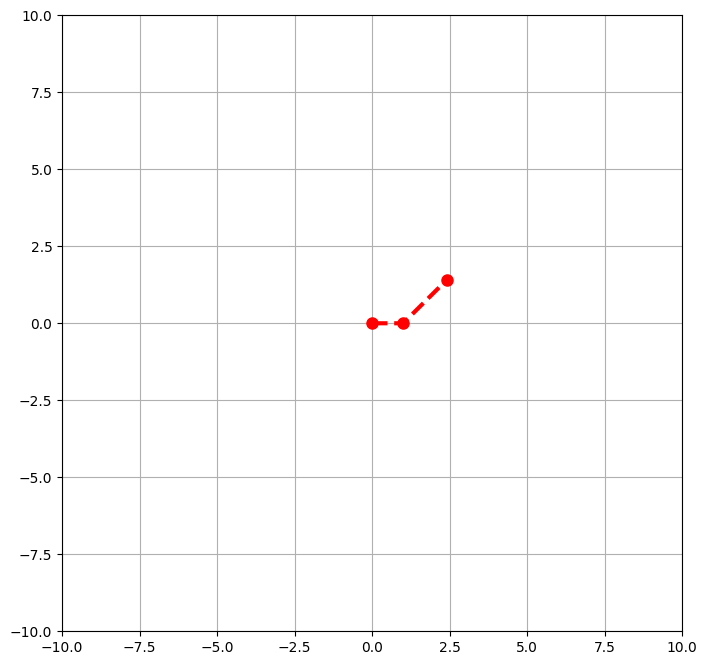

In [34]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-10, 10)
ax.set_xlim(-10,10)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('double_pendulum.gif', writer='pillow', fps=50)